## Run the differential expression analysis protocol

#### Overview
1. Intro of running R on jupyter notebook
2. Ballgown

#### How to run R on jupyter notebook
There is a conda package called irkernel which allows me to run system R on jypyter (Do not use r-essentials pacakge)
Here is the link of the irkernel
https://github.com/IRkernel/IRkernel

#### Load R packages

In [4]:
library(ballgown)
library(RSkittleBrewer)
library(genefilter)
library(dplyr)
library(devtools)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:ballgown’:

    contains, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



#### Load the phenotype data for the samples.
>An example file called geuvadis_phenodata.csv is included with the data files for this protocol (ChrX_data).          
In general, you will have to create this file yourself.     
It contains information about your RNA-seq samples, formatted as illustrated in this csv (comma-separated values) file.      
Each sample should be described on one row of the file,     
and each column should contain one variable. To read this file into R, we use the command read.csv.     
In this file, the values are separated by commas,    
but if the file were tab-delimited you could use the function read.table.

In [5]:
pheno_data = read.csv("chrX_data/geuvadis_phenodata.csv")
pheno_data

ids,sex,population
ERR188044,male,YRI
ERR188104,male,YRI
ERR188234,female,YRI
ERR188245,female,GBR
ERR188257,male,GBR
ERR188273,female,YRI
ERR188337,female,GBR
ERR188383,male,GBR
ERR188401,male,GBR
ERR188428,female,GBR


#### Read in the expression data that were calculated by StringTie. 
>Ballgown also currently supports reading of data from Cufflinks6 and RSEM17. To do this, we use the ballgown command with the following three parameters: the directory in which the data are stored (dataDir, which here is named simply ‘Ballgown’), a pattern that appears in the sample names (samplePattern) and the phenotypic information that we loaded in the previous step (pData). Note that once a Ballgown object is created, any other Bioconductor32 package can be applied for data analysis
or data visualization. Here we present a standardized pipeline that can be used to perform standard differential expression analysis.

In [6]:
bg_chrX = ballgown(dataDir = "ballgown", samplePattern = "ERR", pData=pheno_data)

Fri Dec 30 10:47:50 2016
Fri Dec 30 10:47:50 2016: Reading linking tables
Fri Dec 30 10:47:50 2016: Reading intron data files
Fri Dec 30 10:47:50 2016: Merging intron data
Fri Dec 30 10:47:51 2016: Reading exon data files
Fri Dec 30 10:47:52 2016: Merging exon data
Fri Dec 30 10:47:52 2016: Reading transcript data files
Fri Dec 30 10:47:52 2016: Merging transcript data
Wrapping up the results
Fri Dec 30 10:47:53 2016


In [7]:
bg_chrX

ballgown instance with 3551 transcripts and 12 samples

#### Filter to remove low-abundance genes. 
>One common issue with RNA-seq data is that genes often have very few or zero counts. A common step is to filter out some of these. Another approach that has been used for gene expression analysis is to apply a variance filter. Here we remove all transcripts with a variance across samples less than one:

In [8]:
bg_chrX_filt = subset(bg_chrX,"rowVars(texpr(bg_chrX)) >1",genomesubset=TRUE)

#### Identify transcripts that show statistically significant differences between groups. 
>One thing that we might want to do is make sure that we account for variation in expression due to other variables. As an example, we will look for transcripts that are differentially expressed between sexes, while correcting for any differences in expression due to the population variable. We can do this using the stattest function from Ballgown. We set the getFC=TRUE parameter so that we can look at the confounder-adjusted fold change between the two groups.


>Note that Ballgown’s statistical test is a standard linear model-based comparison. For small sample sizes (n < 4 per group), it is often better to perform regularization. This can be done using the limma package in Bioconductor. Other regularized methods such as DESeq and edgeR can be applied to gene or exon counts, but they are not appropriate for direct application to FPKM abundance estimates. The statistical test uses a cumulative upper
quartile normalizatio.

In [9]:
results_transcripts = stattest(bg_chrX_filt, feature="transcript", covariate="sex",adjustvars = c("population"), getFC=TRUE, meas="FPKM")

#### Identify genes that show statistically significant differences between groups. 
>For this we can run the same function that we used to identify differentially expressed transcripts, but here we set feature="gene" in the stattest command:

In [11]:
results_genes = stattest(bg_chrX_filt, feature="gene", covariate="sex", adjustvars = c("population"), getFC=TRUE, meas="FPKM")

#### Add gene names and gene IDs to the results_transcripts data frame.

In [12]:
results_transcripts = data.frame(geneNames=ballgown::geneNames(bg_chrX_filt), geneIDs=ballgown::geneIDs(bg_chrX_filt), results_transcripts)

#### Sort the results from the smallest P value to the largest

In [13]:
results_transcripts = arrange(results_transcripts,pval)

In [18]:
results_genes = arrange(results_genes,pval)

### TABLE 3 | Differentially expressed transcripts between sexes (q value <5%).

In [17]:
results_transcripts

geneNames,geneIDs,feature,id,fc,pval,qval
.,MSTRG.515,transcript,1691,0.030487043,1.157072e-10,1.606276e-07
XIST,MSTRG.515,transcript,1690,0.002961578,1.463577e-10,1.606276e-07
.,MSTRG.515,transcript,1689,0.015877987,3.579095e-10,2.618704e-07
.,MSTRG.515,transcript,1692,0.028218281,6.929643e-08,3.802641e-05
TSIX,MSTRG.514,transcript,1688,0.077255533,1.774559e-06,7.790315e-04
.,MSTRG.596,transcript,1877,7.400759875,1.366336e-05,4.998512e-03
.,MSTRG.135,transcript,415,3.145541613,2.839402e-05,8.903554e-03
.,MSTRG.601,transcript,1881,9.101151320,5.408241e-05,1.483886e-02
.,MSTRG.751,transcript,2364,0.122910663,7.200314e-05,1.756077e-02
KDM6A,MSTRG.248,transcript,726,0.054303876,1.266323e-04,2.779578e-02


#### Write the results to a csv file that can be shared and distributed:

In [19]:
write.csv(results_transcripts, "chrX_transcript_results.csv", row.names=FALSE)

In [20]:
write.csv(results_genes, "chrX_gene_results.csv", row.names=FALSE)

#### Identify transcripts and genes with a q value <0.05

In [21]:
subset(results_transcripts,results_transcripts$qval<0.05)

geneNames,geneIDs,feature,id,fc,pval,qval
.,MSTRG.515,transcript,1691,0.030487043,1.157072e-10,1.606276e-07
XIST,MSTRG.515,transcript,1690,0.002961578,1.463577e-10,1.606276e-07
.,MSTRG.515,transcript,1689,0.015877987,3.579095e-10,2.618704e-07
.,MSTRG.515,transcript,1692,0.028218281,6.929643e-08,3.802641e-05
TSIX,MSTRG.514,transcript,1688,0.077255533,1.774559e-06,7.790315e-04
.,MSTRG.596,transcript,1877,7.400759875,1.366336e-05,4.998512e-03
.,MSTRG.135,transcript,415,3.145541613,2.839402e-05,8.903554e-03
.,MSTRG.601,transcript,1881,9.101151320,5.408241e-05,1.483886e-02
.,MSTRG.751,transcript,2364,0.122910663,7.200314e-05,1.756077e-02
KDM6A,MSTRG.248,transcript,726,0.054303876,1.266323e-04,2.779578e-02


In [22]:
subset(results_genes,results_genes$qval<0.05)

feature,id,fc,pval,qval
gene,MSTRG.515,0.00237034,2.420952e-11,2.416110e-08
gene,MSTRG.135,3.13164026,3.398352e-06,1.695777e-03
gene,MSTRG.514,0.08184660,6.802107e-06,2.262834e-03
gene,MSTRG.596,7.25231716,1.143388e-05,2.852753e-03
gene,MSTRG.601,9.15509890,4.883227e-05,9.746922e-03
gene,MSTRG.503,0.63885846,1.008894e-04,1.678127e-02
gene,MSTRG.751,0.15472438,1.597860e-04,2.156641e-02
gene,MSTRG.60,0.60121660,1.728770e-04,2.156641e-02
gene,MSTRG.752,0.12368722,2.913779e-04,3.231057e-02
gene,MSTRG.361,0.65086791,3.438442e-04,3.431565e-02


### Data visualization

#### Show the distribution of gene abundances (measured as FPKM values) across samples, colored by sex. 
>Ballgown stores a variety of measurements that can be compared and visualized. For this protocol, we will compare the FPKM measurements for the transcripts, but you can also obtain measurements for each splice junction, exon and gene in the data set. The first command below accesses the FPKM data. The plots will be easier to visualize if you first transform the FPKM data; here we use a log2 transformation that adds one to all FPKM values because log2(0) is undefined (second command below). The third command actually creates the plot

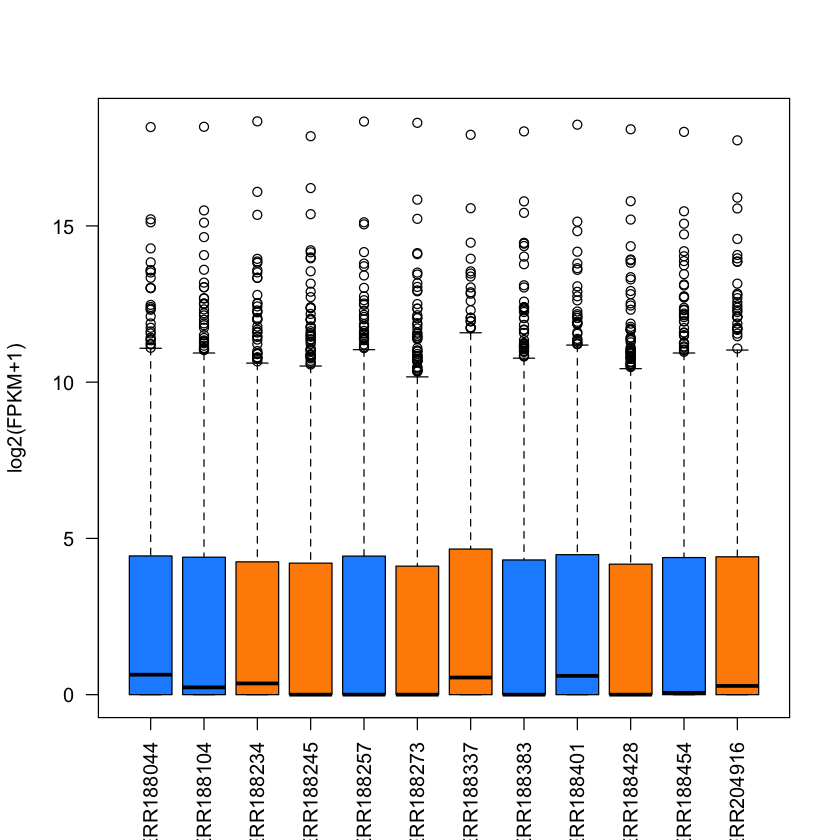

In [23]:
tropical= c('darkorange', 'dodgerblue', 'hotpink', 'limegreen', 'yellow')
palette(tropical)
fpkm = texpr(bg_chrX,meas="FPKM")
fpkm = log2(fpkm+1)
boxplot(fpkm,col=as.numeric(pheno_data$sex),las=2,ylab='log2(FPKM+1)')

#### Make plots of individual transcripts across samples. 
>For example, here we show how to create a plot for the
12th transcript in the data set. The first two commands below show the name of the transcript (NM_012227) and the name of the gene that contains it (GTP binding protein 6, GTPBP6)

In [24]:
ballgown::transcriptNames(bg_chrX)[12]

12 
"MSTRG.5.1"

In [25]:
ballgown::geneNames(bg_chrX)[12]

12 
"."

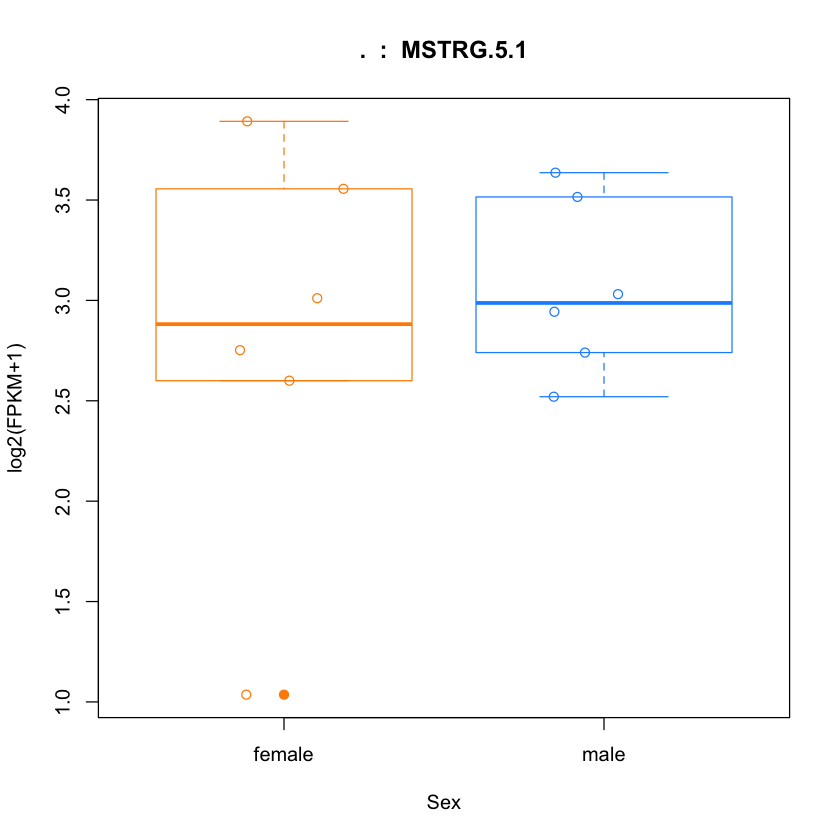

In [26]:
plot(fpkm[12,] ~ pheno_data$sex, border=c(1,2), main=paste(ballgown::geneNames(bg_chrX)[12],' : ', ballgown::transcriptNames(bg_chrX)[12]),pch=19, xlab="Sex", ylab='log2(FPKM+1)')
points(fpkm[12,] ~ jitter(as.numeric(pheno_data$sex)), col=as.numeric(pheno_data$sex))

#### Plot the structure and expression levels in a sample of all transcripts that share the same gene locus. 
>For example, in Figure 5 we show all the transcripts from the gene that contains the first transcript, NR_001564, in Table 3. This is the 1,729th transcript in the Ballgown object according to the id column in the table, and we can easily find the gene ID of the transcript by using ballgown:: geneIDs(bg_chrX)[1729]. This reveals that NR_ 001564 is an isoform of the gene XIST, which is known to be much more highly expressed in females than in males.


>We can see in Table 3 that other isoforms of this gene ap- pear to be differentially expressed as well. We can plot their structure and expression levels by passing the gene name and the Ballgown object to the plotTranscripts func- tion. The plot shows one transcript on each row, colored by its FPKM level. By default, the transcripts at that locus are colored by their expression levels in the first sample, but we can tell the plotTranscripts function which sample we are interested in—here we choose sample ERR188234

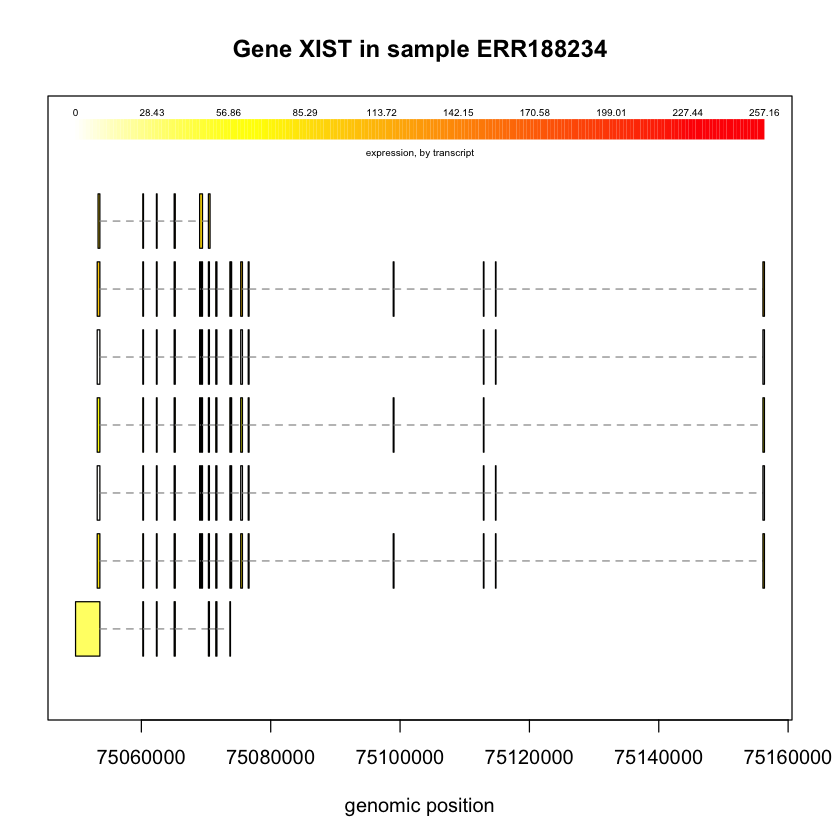

In [29]:
plotTranscripts(ballgown::geneIDs(bg_chrX)[1729], bg_chrX, main=c('Gene XIST in sample ERR188234'), sample=c('ERR188234'))

#### plot the average expression levels for all transcripts of a gene within different groups 
>using the plotMeans function. We need to specify which gene to plot, which Ballgown object to use and which variable to group by. As an example, plot the second gene in Table 4, MSTRG.56, using the following command.

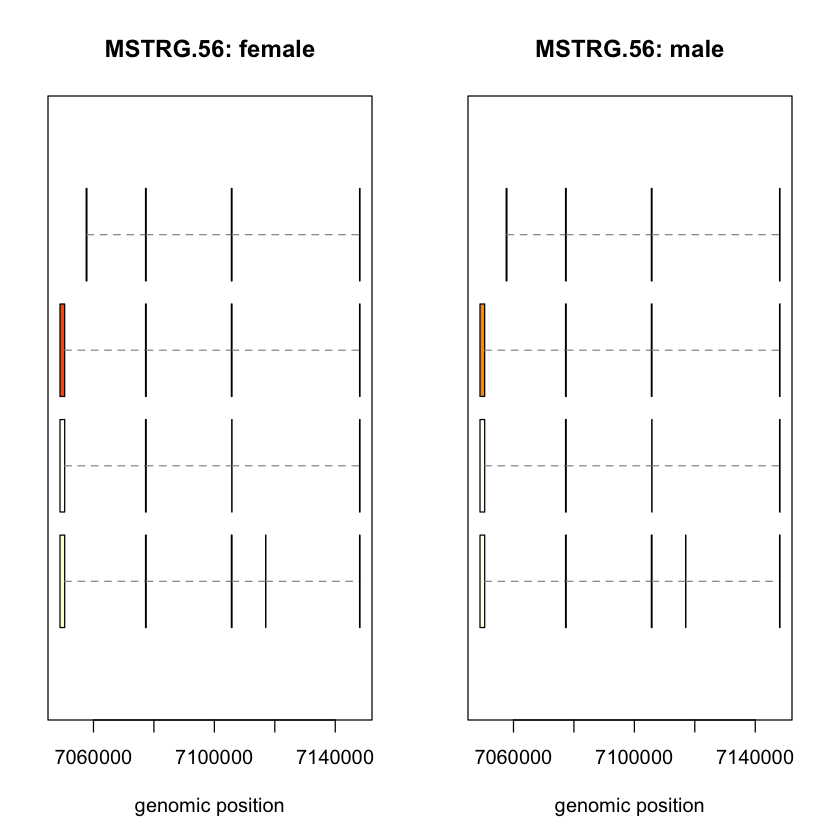

In [30]:
plotMeans('MSTRG.56', bg_chrX_filt,groupvar="sex",legend=FALSE)

#### the overall distribution of P values that measure differential expression at both the transcript and gene levels. 

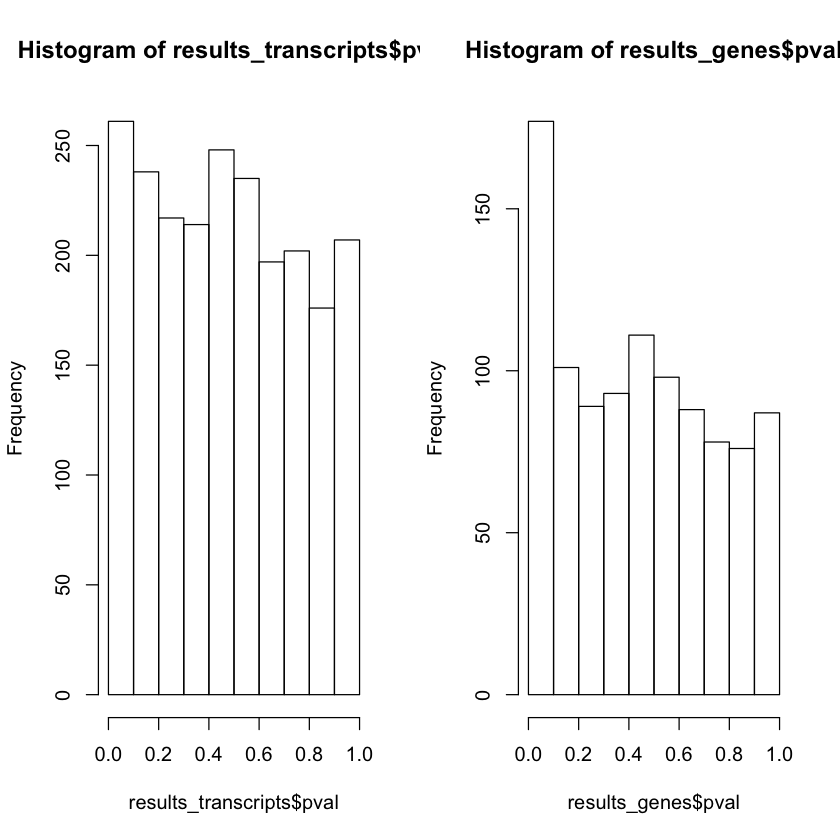

In [37]:
par(mfrow=c(1,2))
hist(results_transcripts$pval)
hist(results_genes$pval)